In [1]:
import numpy as np
import random
import skimage.data as da
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
import cv2
from sklearn.cluster import KMeans
import os
import skimage.io as io
from skimage.filters import threshold_otsu
import math

In [2]:
# implementation of utsu's 

def make_histogram(img):
    '''make intensity histogram
    code from: https://stackoverflow.com/questions/22159160/python-calculate-histogram-of-image'''
    vals = img.flatten()
    counts, bins = np.histogram(vals, range(257))
    bins = bins[:-1]
    return bins,counts

def probability_below_t(t,counts,bins):
    """computes w1"""
    nr_pixels_smaller_than_t = counts[bins<t].sum()
    nr_of_pixels_in_image = counts.sum()
    probability = nr_pixels_smaller_than_t/nr_of_pixels_in_image
    return probability

def probability_above_equal_t(t,counts,bins):
    """computes w2"""
    nr_pixels_above_equal__t = counts[bins>=t].sum()
    nr_of_pixels_in_image = counts.sum()
    probability = nr_pixels_above_equal__t/nr_of_pixels_in_image
    return probability  

def compute_mu1(t, counts,bins):
    mu1 = (bins[bins<t]*counts[bins<t]).sum()/counts[bins<t].sum()
    return mu1

def compute_mu2(t,counts,bins):
    """computes mean pixel value in the class below t"""
    mu2 = (bins[bins>=t]*counts[bins>=t]).sum()/counts[bins>=t].sum()
    return mu2 

def get_iterclass_var(t, counts,bins):
    w1 = probability_below_t(t,counts,bins)
    w2 = probability_above_equal_t(t,counts,bins)
    mu1 = compute_mu1(t, counts,bins)
    mu2 = compute_mu2(t, counts,bins)
    muT= (bins*counts).sum()/counts.sum()
    sigma_b_2 = w1*(mu1-muT)**2 + w2*(mu2-muT)**2
    return sigma_b_2

def utsu_threshold(img):
    '''returns the threshold pixel intensity that separates in to two classes where the interclass pixel intensity is the largest'''
    bins,counts = make_histogram(img)
    muT= (bins*counts).sum()/counts.sum()
    interclass_vars = []
    for t in range(1,257):#search th
        interclass_var = get_iterclass_var(t, counts,bins) 
        interclass_vars.append(interclass_var)
    interclass_vars = [0 if math.isnan(x) else x for x in interclass_vars] #replace nan with 0. TODO find out why there is a nan
    threshold = interclass_vars.index(max(interclass_vars)) #threshold is the pixelintensity(same as the index) with the highest interclass variance
    return threshold





In [3]:
def lloyd(image, k):
    shape = image.shape
    reshaped = image.reshape(-1, 1)

    kmeans = KMeans(n_clusters = k).fit(reshaped)
    cluster_centers = kmeans.cluster_centers_
    cluster_labels = kmeans.labels_
    image_flat = cluster_centers[cluster_labels]
    
    return image_flat.reshape(shape)

from collections import Counter

# most common function taken from:
# https://stackoverflow.com/questions/1518522/find-the-most-common-element-in-a-list
def most_common(lst):
    return max(set(lst), key=lst.count)

def clean(img, num_pix = 8, iters = 5):
    
    # initialize an emtpy output matrix in the same shape as input image
    # output = np.zeros((img.shape[0], img.shape[1]))
    img = img.copy()
    
    for i in range(iters):
    # iter over the emtpy output image and fill in the values
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                # TBD: what to do with the edges?
                if i == 0 or i == img.shape[0]-1 or j == 0 or j == img.shape[1]-1:
                    continue
                else:
                    change_list = [img[i, j]]
                    content = img[i-1:i+2, j-1:j+2]

                    if num_pix == 8:
                        change_list = list(content.flatten())

                    else:
                        array = np.array([[False, True, False],
                                           [True, True, True],
                                           [False, True, False]])
                        change_list = list(content[array].flatten())

                    # assign the output images pixel value 
                    # the most frequent value over all the values of our list
                    img[i, j] = most_common(change_list)

    return img

In [4]:
# All images from absalon
path = "data"
images = [io.imread(os.path.join(path,filename)) for filename in os.listdir(path)]

In [5]:
lloyd_imgs = []
otsu_imgs = []

for image in images:
    lloyd_img = lloyd(image, 2)
    lloyd_imgs.append(lloyd_img)
#     thresh = threshold_otsu(image) #from skimage 
    thresh = utsu_threshold(image) #manually implemented
    otsu = image > thresh
    otsu_imgs.append(otsu)


<ipython-input-2-496f268ca449>:31: RuntimeWarning: invalid value encountered in longlong_scalars
  mu2 = (bins[bins>=t]*counts[bins>=t]).sum()/counts[bins>=t].sum()
<ipython-input-2-496f268ca449>:26: RuntimeWarning: invalid value encountered in longlong_scalars
  mu1 = (bins[bins<t]*counts[bins<t]).sum()/counts[bins<t].sum()
<ipython-input-2-496f268ca449>:31: RuntimeWarning: invalid value encountered in longlong_scalars
  mu2 = (bins[bins>=t]*counts[bins>=t]).sum()/counts[bins>=t].sum()
<ipython-input-2-496f268ca449>:31: RuntimeWarning: invalid value encountered in longlong_scalars
  mu2 = (bins[bins>=t]*counts[bins>=t]).sum()/counts[bins>=t].sum()
<ipython-input-2-496f268ca449>:31: RuntimeWarning: invalid value encountered in longlong_scalars
  mu2 = (bins[bins>=t]*counts[bins>=t]).sum()/counts[bins>=t].sum()


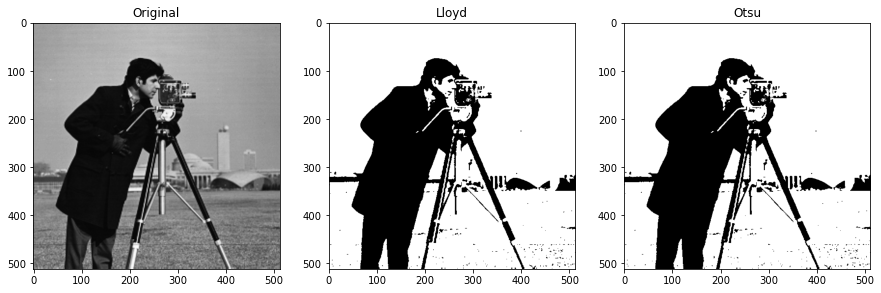

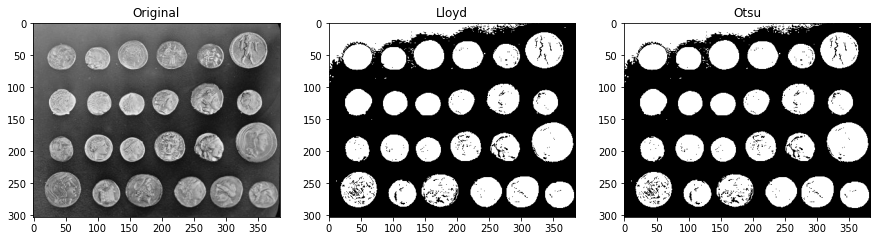

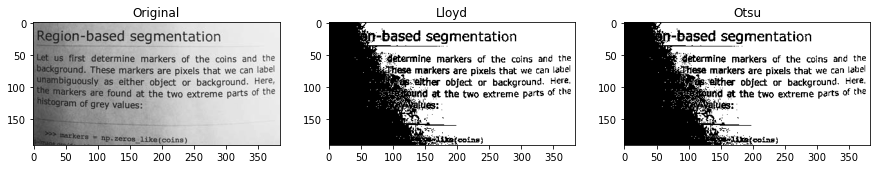

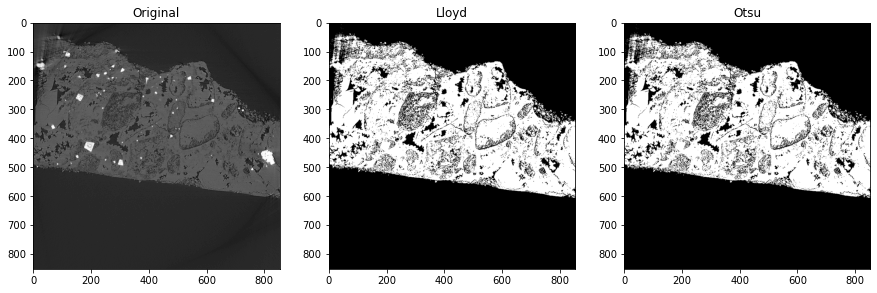

In [6]:
for idx in range(0, len(images)):
    fig, ax = plt.subplots(1,3,figsize=(15,5))
    ax[0].imshow(images[idx], cmap='gray')
    ax[0].set_title('Original')
    # NOTE: centroids of image are the mean of the colors instead of 1 and 0

    ax[1].imshow(lloyd_imgs[idx],cmap='gray')
    ax[1].set_title('Lloyd')

    ax[2].imshow(otsu_imgs[idx],cmap='gray')
    ax[2].set_title('Otsu')

    plt.show()

In [7]:
cleaned_lloyd = []
iterations = [1,5]
pixels = [8, None]

a = clean(lloyd_imgs[2], pixels[0], iterations[0])
b = clean(lloyd_imgs[2], pixels[0], iterations[1])
c = clean(lloyd_imgs[2], pixels[1], iterations[0])
d = clean(lloyd_imgs[2], pixels[1], iterations[1])

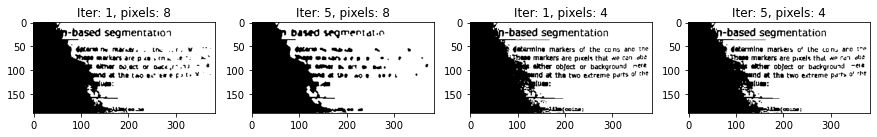

In [8]:
fig, ax = plt.subplots(1,4,figsize=(15,5))
ax[0].imshow(a, cmap='gray')
ax[0].set_title('Iter: 1, pixels: 8')
# NOTE: centroids of image are the mean of the colors instead of 1 and 0

ax[1].imshow(b,cmap='gray')
ax[1].set_title('Iter: 5, pixels: 8')

ax[2].imshow(c,cmap='gray')
ax[2].set_title('Iter: 1, pixels: 4')

ax[3].imshow(d,cmap='gray')
ax[3].set_title('Iter: 5, pixels: 4')

plt.show()